# Option Pricing with QuantLib and Python
[Gouthaman Balaraman](http://gouthamanbalaraman.com)

I have written about option pricing earlier. The [introduction to option pricing](http://gouthamanbalaraman.com/blog/option-model-handbook-part-I-introduction-to-option-models.html) gave an overview of the theory behind option pricing. The post on [introduction to binomial trees](http://gouthamanbalaraman.com/blog/option-model-handbook-part-II-introduction-to-binomial-trees.html) outlined the binomial tree method to price options.

In this post, we will use QuantLib and the Python extension to illustrate a very simple example. Here we are going to price a European option using the Black-Scholes-Merton formula. We will price them again using the Binomial tree and understand the agreement between the two. 

In [1]:
import QuantLib as ql # version 1.5
import matplotlib.pyplot as plt
%matplotlib inline

Let us consider a European call option for AAPL with a strike price of \$130 maturing on 15th Jan, 2016. Let the spot price be \$127.62. The volatility of the underlying stock is know to be 20%, and has a dividend yield of 1.63%. Lets value this option as of 8th May, 2015.

In [2]:
# option data
maturity_date = ql.Date(15, 1, 2016)
spot_price = 127.62
strike_price = 130
volatility = 0.20 # the historical vols for a year
dividend_rate =  0.0163
option_type = ql.Option.Call

risk_free_rate = 0.001
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

calculation_date = ql.Date(8, 5, 2015)
ql.Settings.instance().evaluationDate = calculation_date

We construct the European option here.

In [3]:
# construct the European Option
payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, exercise)

The Black-Scholes-Merto process is constructed here.

In [4]:
spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(spot_price)
)
flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count)
)
dividend_yield = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count)
)
flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)
)
bsm_process = ql.BlackScholesMertonProcess(spot_handle, 
                                           dividend_yield, 
                                           flat_ts, 
                                           flat_vol_ts)

Lets compute the theoretical price using the `AnalyticEuropeanEngine`.

In [6]:
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
bs_price = european_option.NPV()
print("The theoretical price is ", bs_price)

The theoretical price is  6.749271812460607


Lets compute the price using the binomial-tree approach.

In [7]:
def binomial_price(bsm_process, steps):
    binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", steps)
    european_option.setPricingEngine(binomial_engine)
    return european_option.NPV()

steps = range(2, 100, 1)
prices = [binomial_price(bsm_process, step) for step in steps]

In the plot below, we show the convergence of binomial-tree approach by comparing its price with the BSM price.

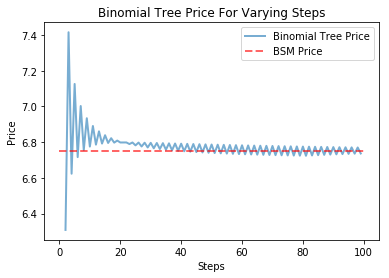

In [8]:
plt.plot(steps, prices, label="Binomial Tree Price", lw=2, alpha=0.6)
plt.plot([0,100],[bs_price, bs_price], "r--", label="BSM Price", lw=2, alpha=0.6)
plt.xlabel("Steps")
plt.ylabel("Price")
plt.title("Binomial Tree Price For Varying Steps")
plt.legend()